In [2]:
# Importing libraries

import re
import pandas as pd
import numpy as np
import nltk
# nltk.download('all')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import precision_score, recall_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Dense, Flatten, Dropout, BatchNormalization, SimpleRNN,TimeDistributed, LSTM
from tensorflow.keras import Sequential

#### Dataset Loading

In [3]:
# reading data

data = pd.read_csv(r'googleplaystore_user_reviews.csv')

data.head()

,App,Translated_Review,Sentiment
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive
2,10 Best Foods for You,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive
4,10 Best Foods for You,Best idea us,Positive


In [4]:
# drop unnecessary columns and rename cols

data.drop(['App'], axis=1, inplace=True)

data.columns = ['review', 'sentiment']

data.head()

,review,sentiment
0,I like eat delicious food. That's I'm cooking ...,Positive
1,This help eating healthy exercise regular basis,Positive
2,NaN,NaN
3,Works great especially going grocery store,Positive
4,Best idea us,Positive


#### EDA

In [5]:
# check data shape

data.shape

(64295, 2)

In [6]:
# check missing values

data.isna().sum()

,0
review,26868
sentiment,26863


In [7]:
# dropping null values

data.dropna(inplace=True)

<Axes: xlabel='sentiment'>

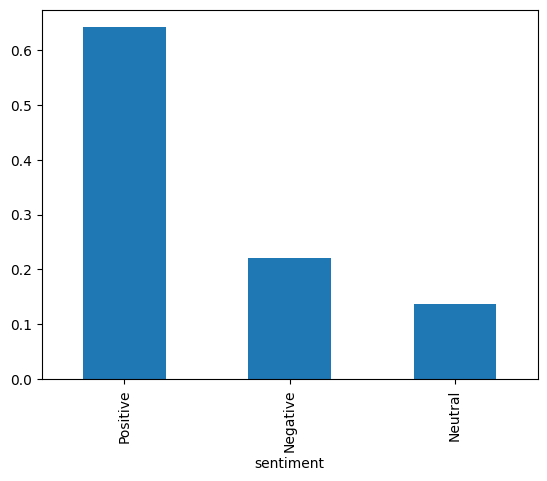

In [8]:
# check target balance

data['sentiment'].value_counts(normalize = True).plot.bar()

#### Text Preprocessing pipeline

In [9]:
# text preprocessing

def preprocess_pipeline(text_data):
    # create a list text

    lemmatizer = WordNetLemmatizer()

    if str(type(text_data)) != "<class 'str'>":
        text = list(text_data)

        # preprocessing loop

        corpus = []

        for i in range(len(text)):

            r = re.sub('[^a-zA-Z]', ' ', text[i])

            r = r.lower()

            r = r.split()

            # r = [word for word in r if word not in stopwords.words('english')]

            # r = [lemmatizer.lemmatize(word) for word in r]

            r = ' '.join(r)

            corpus.append(r)

        return corpus

    else:

        r = re.sub('[^a-zA-Z]', ' ', text_data)

        r = r.lower()

        r = r.split()

        r = [word for word in r if word not in stopwords.words('english')]

        r = [lemmatizer.lemmatize(word) for word in r]

        r = ' '.join(r)

        return r

In [10]:
#assign corpus to data['text']
preprocessed_text = preprocess_pipeline(data['review'])

In [11]:
data['review'] = preprocessed_text

data.head()

,review,sentiment
0,i like eat delicious food that s i m cooking f...,Positive
1,this help eating healthy exercise regular basis,Positive
3,works great especially going grocery store,Positive
4,best idea us,Positive
5,best way,Positive


In [12]:
# data.to_csv('sentiments_cleaned_data.csv', index=False)

In [13]:
data.head()

,review,sentiment
0,i like eat delicious food that s i m cooking f...,Positive
1,this help eating healthy exercise regular basis,Positive
3,works great especially going grocery store,Positive
4,best idea us,Positive
5,best way,Positive


#### Train-Test split

In [14]:
# Create Feature and Label sets

X = data['review']

y = data['sentiment']


# train test split (66% train - 33% test)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


print('Training Data :', X_train.shape)

print('Testing Data : ', X_test.shape)

Training Data : (26198,)
Testing Data :  (11229,)


In [15]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

le.fit(y)

y_train = le.transform(y_train)
y_test = le.transform(y_test)

#### Feature Extraction

#### Using Embeddings in Keras library

In [16]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [17]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

17518

In [18]:
# Pad the sequences to a fixed length
max_length = 10
X_train = pad_sequences(X_train, maxlen=max_length, padding='pre')
X_test = pad_sequences(X_test, maxlen=max_length, padding='pre')

In [19]:
# Define the ANN model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=5, input_length=max_length))
model.add(LSTM(150,return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
'''
Output Shape: (None, 10, 5)
Formula for Parameters: Total Parameters=vocab_size×output_dim
Given Parameters: 87,590
vocab_size×5=87,590
So, vocab_size = 17,518 and output_dim = 5.

2. LSTM Layer (LSTM)

LSTM(150, return_sequences=False)
Output Shape: (None, 150)
Formula for Parameters in LSTM:
For an LSTM with n units and m input features:
Total Params=4×(n×(n+m+1))
where:

4 → for input, forget, cell, and output gates.
n = 150 (LSTM units).
m = 5 (input from Embedding layer, output_dim).
Substituting Values:
4×(150×(150+5+1)) = 4×(150×156)=4×23,400=93,600
So,The LSTM layer has 93,600 parameters.

Dropout Layer (Dropout)

Dropout(0.2)
Output Shape: (None, 150)
Dropout has no trainable parameters!
So,Total Parameters = 0

4.Dense Layer (Dense)

Dense(3, activation='softmax')
Output Shape: (None, 3)
Formula for Parameters:
Total Params=(input units×output units)+bias
where:

Input units = 150 (from LSTM).
Output units = 3 (number of classes).
Bias = 3 (one per output neuron).
So, Substituting Values:
(150×3)+3=450+3=453
The Dense layer has 453 parameters.

'''

In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 10, 5)               │          87,590 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 150)                 │          93,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 150)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │             453 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 544,931 (2.08 MB)

 Trainable params: 181,643 (709.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 363,288 (1.39 MB)

In [20]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.6627 - loss: 0.8130 - val_accuracy: 0.7708 - val_loss: 0.5355
Epoch 2/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8182 - loss: 0.4544 - val_accuracy: 0.8197 - val_loss: 0.4649
Epoch 3/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8847 - loss: 0.3074 - val_accuracy: 0.8246 - val_loss: 0.4627
Epoch 4/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9126 - loss: 0.2435 - val_accuracy: 0.8277 - val_loss: 0.4844
Epoch 5/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9347 - loss: 0.1922 - val_accuracy: 0.8210 - val_loss: 0.5865
Epoch 6/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9448 - loss: 0.1650 - val_accuracy: 0.8260 - val_loss: 0.5673
Epoch 7/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9518 - loss: 0.1478 - val_accuracy: 0.8281 - val_loss: 0.6359
Epoch 8/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9597 - loss: 0.1253 - val_accuracy: 0

In [21]:
probabilities = model.predict(X_test)

probabilities

351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


array([[2.8338142e-02, 9.2556523e-03, 9.6240622e-01],
       [8.9663935e-01, 1.9488154e-02, 8.3872475e-02],
       [9.5913559e-03, 7.9893292e-04, 9.8960972e-01],
       ...,
       [9.4340104e-01, 5.2064039e-02, 4.5349346e-03],
       [1.0760993e-02, 5.2166445e-04, 9.8871732e-01],
       [9.8098916e-01, 9.2968224e-03, 9.7139832e-03]], dtype=float32)

In [22]:
predictions = np.argmax(probabilities, axis=1)

predictions

array([2, 0, 2, ..., 0, 2, 0])

In [23]:
# confusion matrix
from sklearn import metrics

df = pd.DataFrame(metrics.confusion_matrix(y_test,predictions),index=['Negative','Neutral','Positive'], columns=['Negative','Neutral','Positive'])

df

,Negative,Neutral,Positive
Negative,1666,167,648
Neutral,112,1102,334
Positive,673,188,6339


In [24]:
precision = precision_score(y_test, predictions, average='weighted')
recall = recall_score(y_test, predictions, average='weighted')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Precision: 0.81
Recall: 0.81
